# 0 简介

教程：https://www.freesion.com/article/7349452155/#335__467
本文通过LSTM模型进行时间序列预测，分为三种情况：
1. 窗口内根据单个属性预测单个未来时间点；
2. 窗口内根据多个属性预测单个未来时间点；
3. 窗口内根据多个属性预测多个未来时间点；

In [1]:
import os
import matplotlib
# matplotlib.use('GTK3Agg')
# matplotlib.use('agg') # 使用非交互式后端，pycharm中不显示图片，但可以输出图片
matplotlib.rcParams['figure.figsize'] = (4, 3)
matplotlib.rcParams['axes.grid'] = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

## 全局变量

In [2]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

## 加载数据

In [3]:
data_path = "data/jena_climate_2009_2016.csv"
df = pd.read_csv(data_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## 可视化图表函数

In [4]:
def create_time_steps(length):
    return list(range(-length, 0))
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])  # 返回-20到-1的列表
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2]) # x刻度从-len开始，到(delta + 5) * 2结束
    plt.xlabel('Time-Step')
    return plt
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

# 1. 单变量预测单个未来时间点

## 读取温度数据

In [5]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<AxesSubplot:xlabel='Date Time'>], dtype=object)

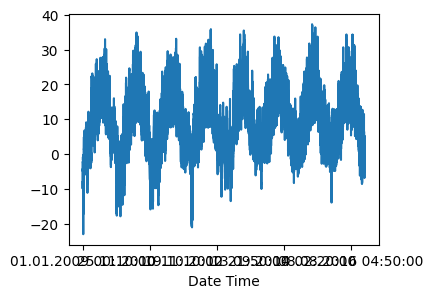

In [6]:
uni_data.plot(subplots=True)

## 数据处理

In [7]:
# dataframe转array
uni_data = uni_data.values
uni_data.shape

(420551,)

In [8]:
# 标准化
TRAIN_SPLIT = 300000
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data - uni_train_mean)/uni_train_std

In [9]:
# 从dataset中获取[start_index:end_index]的部分，特征窗口为history_size，预测位置为target_size
# 用[i-history_size:i]预测i+target_size
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

In [10]:
# 训练集为前300000条，测试集为剩余的
univariate_past_history = 20
univariate_future_target = 0
x_train, y_train = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                   univariate_past_history,
                                   univariate_future_target)
x_val, y_val = univariate_data(uni_data, TRAIN_SPLIT, None,
                               univariate_past_history,
                               univariate_future_target)

In [11]:
# history_size=20，target_size=0，比如用前20条数据来预测第20条
print(uni_data[:20])
print ('Single window of past history')
print (x_train[0])
print ('\n Target temperature to predict')
print (y_train[0])

[-1.99766294 -2.04281897 -2.05439744 -2.0312405  -2.02660912 -2.00113649
 -1.95134907 -1.95134907 -1.98492663 -2.04513467 -2.08334362 -2.09723778
 -2.09376424 -2.09144854 -2.07176515 -2.07176515 -2.07639653 -2.08913285
 -2.09260639 -2.10418486]
Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


<module 'matplotlib.pyplot' from 'D:\\ZJU\\Anaconda3\\envs\\learned_index\\lib\\site-packages\\matplotlib\\pyplot.py'>

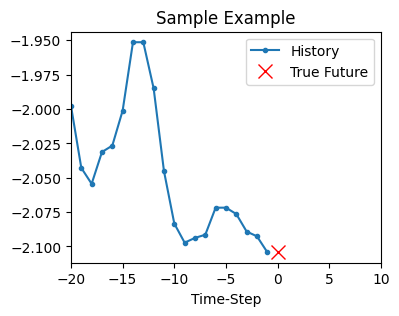

In [12]:
show_plot([x_train[0], y_train[0]], 0, 'Sample Example')

## 切片

In [13]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [14]:
for x, y in val_univariate.take(1):
    print(x.shape)
    print(y.shape)

(256, 20, 1)
(256,)


## 构建模型

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]), # (20, 1)
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mae')

## 训练模型

In [17]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

model.fit(train_univariate, epochs=EPOCHS,
          steps_per_epoch=EVALUATION_INTERVAL,
          validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 7ms/step - loss: 0.3483 - val_loss: 0.0604
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0666 - val_loss: 0.0301
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0382 - val_loss: 0.0237
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0345 - val_loss: 0.0221
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0245 - val_loss: 0.0207
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0275 - val_loss: 0.0196
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0257 - val_loss: 0.0187
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0239 - val_loss: 0.0180
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0236 - val_loss: 0.0180
Epoch 10/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0216 - val_loss: 0.0166

## 推理模型

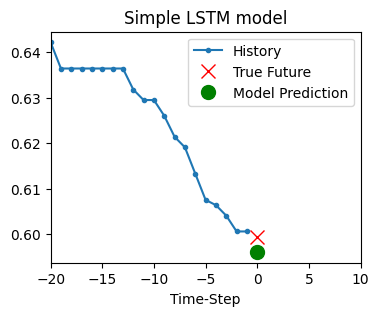

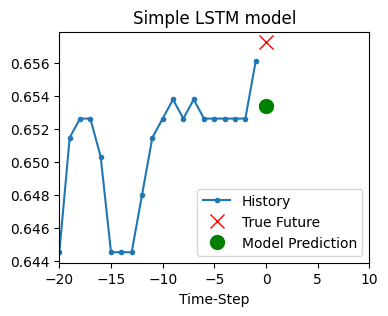

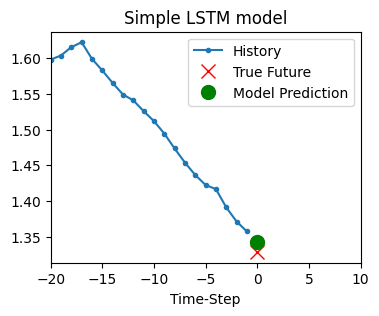

In [18]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

## 清空数据

In [19]:
del train_univariate
del val_univariate

# 2. 多变量预测单个未来时间点

## 读取多变量数据

In [20]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>], dtype=object)

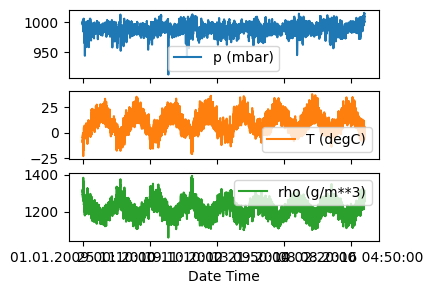

In [21]:
features.plot(subplots=True)

## 数据处理

In [22]:
# 标准化
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset - data_mean)/data_std

In [23]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [24]:
# step表示在target_size个特征里，每step个只取一个特征，比如720的特征里，每6个取一个，则最后取720/6=120个
past_history = 720
future_target = 72
STEP = 6

x_train, y_train = multivariate_data(dataset, dataset[:, 1], 0,
                                   TRAIN_SPLIT, past_history,
                                   future_target, STEP,
                                   single_step=True)
x_val, y_val = multivariate_data(dataset, dataset[:, 1],
                               TRAIN_SPLIT, None, past_history,
                               future_target, STEP,
                               single_step=True)

In [25]:
print ('Single window of past history : {}'.format(x_train[0].shape))
print ('Target temperature to predict : {}'.format(y_train[0].shape))

Single window of past history : (120, 3)
Target temperature to predict : ()


## 切片

In [29]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

## 构建模型

In [30]:
x_train.shape[-2:]

(120, 3)

In [31]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32, input_shape=x_train.shape[-2:])) # (120, 3)
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

## 训练模型

In [32]:
model.fit(train_data, epochs=EPOCHS,
        steps_per_epoch=EVALUATION_INTERVAL,
        validation_data=val_data,
        validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 15ms/step - loss: 0.3144 - val_loss: 0.2618
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2618 - val_loss: 0.2440
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2586 - val_loss: 0.2433
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2569 - val_loss: 0.2365
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2260 - val_loss: 0.2310
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2372 - val_loss: 0.2528
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2406 - val_loss: 0.2473
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2411 - val_loss: 0.2421
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2406 - val_loss: 0.2521
Epoch 10/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2388 - val_lo

## 推理模型

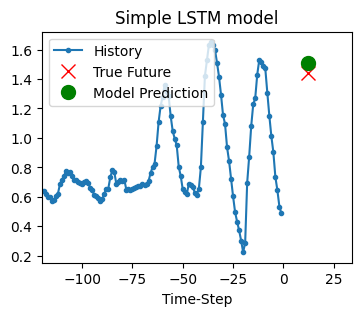

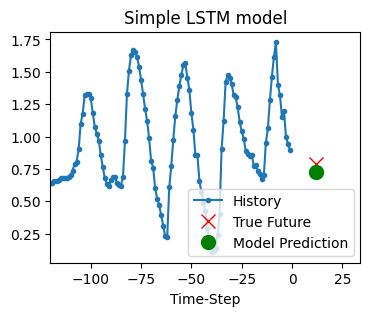

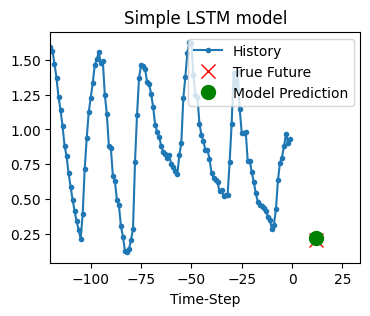

In [33]:
for x, y in val_data.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 12,
                   'Simple LSTM model')
    plot.show()

## 清空数据

In [34]:
del train_data
del val_data

# 3. 多变量预测多未来时间点

## 读取多变量数据

## 数据处理

In [35]:
# single_step为false，表示为多未来时间点预测
past_history = 720
future_target = 72
STEP = 6
x_train, y_train = multivariate_data(dataset, dataset[:, 1], 0,
                                   TRAIN_SPLIT, past_history,
                                   future_target, STEP,
                                   single_step=False)
x_val, y_val = multivariate_data(dataset, dataset[:, 1],
                               TRAIN_SPLIT, None, past_history,
                               future_target, STEP,
                               single_step=False)

In [36]:
print ('Single window of past history : {}'.format(x_train[0].shape))
print ('Target temperature to predict : {}'.format(y_train[0].shape))

Single window of past history : (120, 3)
Target temperature to predict : (72,)


## 切片

In [37]:
# 一样
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

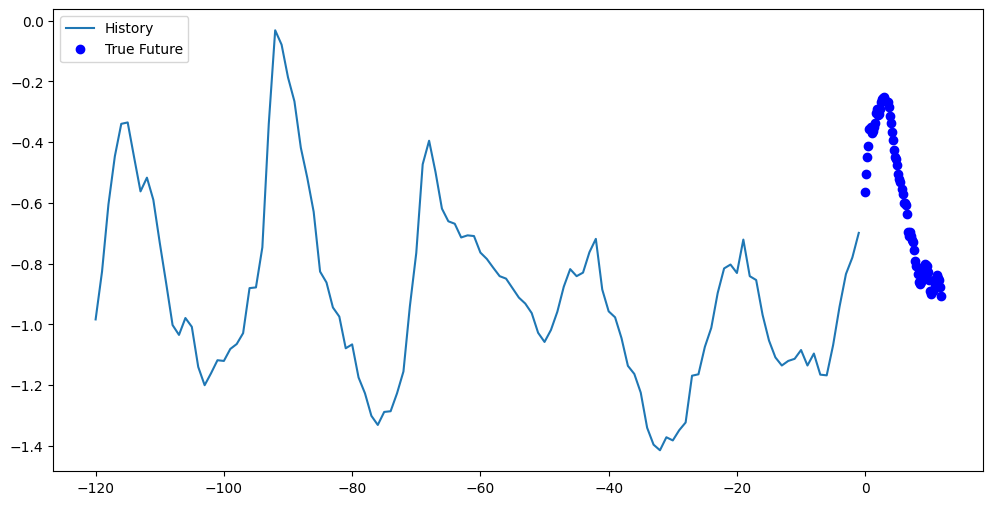

In [38]:
for x, y in train_data.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

## 构建模型

In [39]:
x_train.shape[-2:]

(120, 3)

In [40]:
# 输入层对了return_sequences=True，加一个隐藏层，输出层神经元1改为72
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train.shape[-2:])) # (120, 3)
model.add(tf.keras.layers.LSTM(16, activation='relu'))
model.add(tf.keras.layers.Dense(72))
model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

## 训练模型

In [41]:
model.fit(train_data, epochs=EPOCHS,
        steps_per_epoch=EVALUATION_INTERVAL,
        validation_data=val_data,
        validation_steps=50)

Epoch 1/10
200/200 [==============================] - 42s 201ms/step - loss: 0.8704 - val_loss: 0.3271
Epoch 2/10
200/200 [==============================] - 40s 198ms/step - loss: 0.3502 - val_loss: 0.2794
Epoch 3/10
200/200 [==============================] - 40s 202ms/step - loss: 0.3209 - val_loss: 0.2409
Epoch 4/10
200/200 [==============================] - 41s 204ms/step - loss: 0.2430 - val_loss: 0.2113
Epoch 5/10
200/200 [==============================] - 40s 200ms/step - loss: 0.2025 - val_loss: 0.2003
Epoch 6/10
200/200 [==============================] - 41s 204ms/step - loss: 0.2107 - val_loss: 0.2218
Epoch 7/10
200/200 [==============================] - 41s 204ms/step - loss: 0.2013 - val_loss: 0.2032
Epoch 8/10
200/200 [==============================] - 40s 202ms/step - loss: 0.1984 - val_loss: 0.1985
Epoch 9/10
200/200 [==============================] - 40s 198ms/step - loss: 0.1993 - val_loss: 0.2002
Epoch 10/10
200/200 [==============================] - 41s 204ms/step - l

## 推理模型

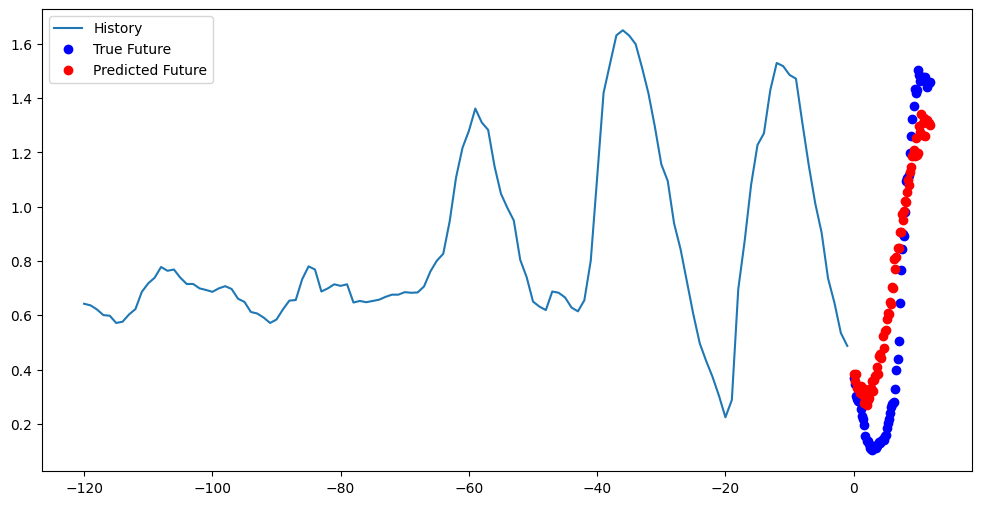

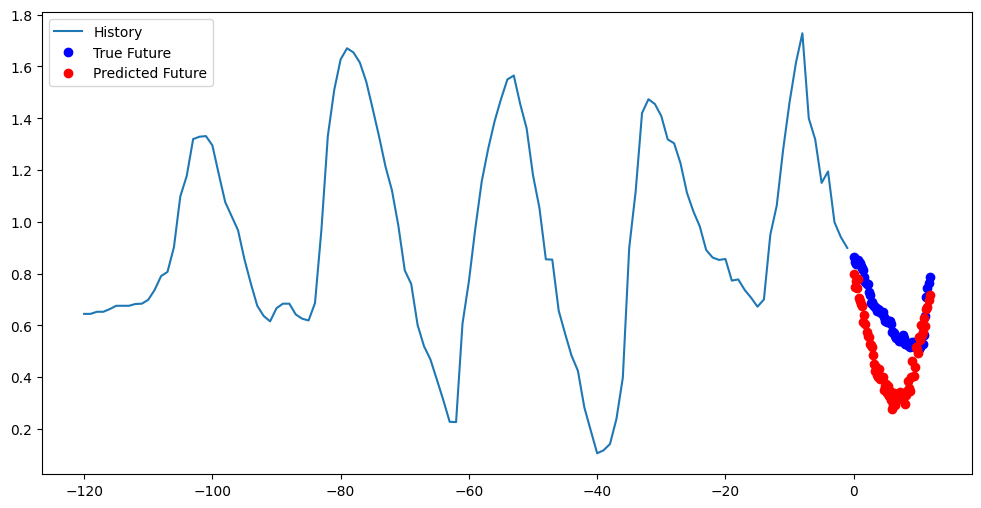

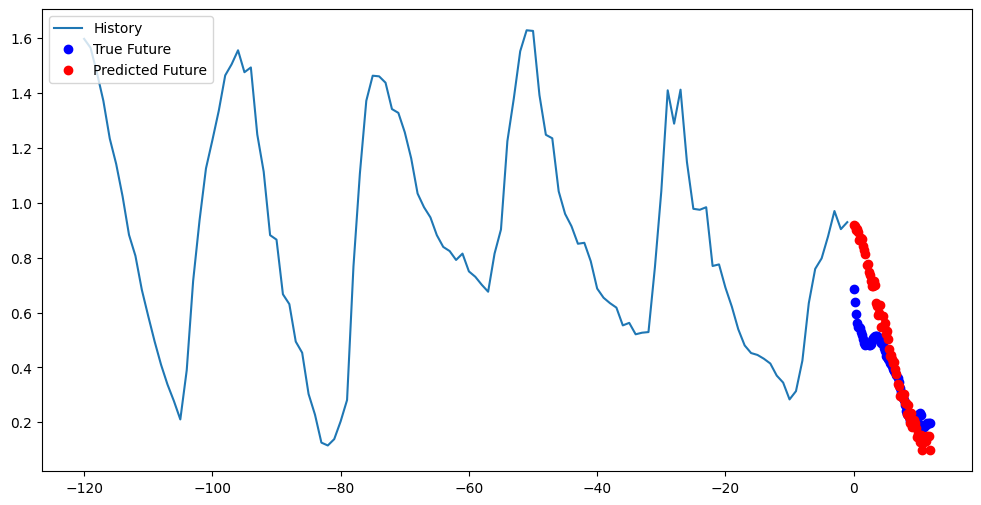

In [42]:
for x, y in val_data.take(3):
    multi_step_plot(x[0], y[0], model.predict(x)[0])

## 清空数据

In [43]:
del train_data
del val_data